# This notebook generates figure 06, which shows a raw data comparison between 150 keV and 2400 keV data taken immediately one after the other proving that suppression does not require damage.

In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

import sys, os, importlib, seaborn as sns, pandas as pd

outputDirectory = 'raw/'
parentDirectory = 'data/'
sys.path.append('../../../')
sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation/')

import default_style as dfs
import hts_dosecalculations as dose
import hts_fitfunctions as ff

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import hts_fitting as hts, hts_fitfunctions as ff, hts_misc as misc, default_style as dfs, hts_beamspot as bsp
for lib in [hts, ff, misc, dfs, bsp]:
    importlib.reload(lib)

########## Load data ############
#################################
masterfile = '/Users/alexisdevitre/Documents/GitHub/2025-devitre-PhD/chapter 4/figures/4-3 Degradation enhances suppression/data/data-master-linear.xlsx'
cols = [0, 12, 13, 14, 41, 55, 56, 59]
names = ['tapeid', 'energy', 'power', 'powerError', 'tTAR_OFF', 'suppression', 'suppressionError', 'outlier']
df = pd.read_excel(masterfile, sheet_name='data', usecols=cols, names=names, skiprows=1)


########## Filter data ##########
#################################
cut = df.tTAR_OFF <= 20
cut &= (df.suppression != np.nan) & (df.suppression > 0) & (df.suppressionError > 0)
cut &= df.outlier != 1
data = df[cut]

########## Describe data ##########
###################################
print('\n\nTotal datapoints', data.energy.count())
for tapeid in data.tapeid.unique():
    print('\nDatapoints for', tapeid, data[data.tapeid==tapeid].energy.count())

df.columns



Total datapoints 656

Datapoints for f33 68

Datapoints for f20 11

Datapoints for f34 9

Datapoints for f29 302

Datapoints for f23 2

Datapoints for f28 58

Datapoints for f37 206


Index(['tapeid', 'energy', 'power', 'powerError', 'tTAR_OFF', 'suppression',
       'suppressionError', 'outlier'],
      dtype='object')

## Figure description

This figure compares raw beam on data with two different energies for sample ffj37. The data were acquired sequentially, without intermediate anneals. The open circles are 150 keV proton beams, which do not damage the tape but deposit deat in the top silver layer. The yellow triangles are 2400 keV proton beams, which damage and heat the tape. This figure demonstrates that direct interactions between REBCO and the beam are not necessary to produce the "beam on effect".

In [11]:
popt

array([0.0037352])

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_93467/105207096.py:12: SyntaxWarning: invalid escape sequence '\m'
  labels = ['No damage in REBCO layer (150 keV)', '4 x $\mathrm{10^{-5}}$ mdpa/s in REBCO (2400 keV)']
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_93467/105207096.py:22: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Suppression $\mathrm{1 - I_c^{On}\, /\, I_c^{Off}}$ [%]')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_93467/105207096.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Suppression $\mathrm{1 - I_c^{On}\, /\, I_c^{Off}}$')


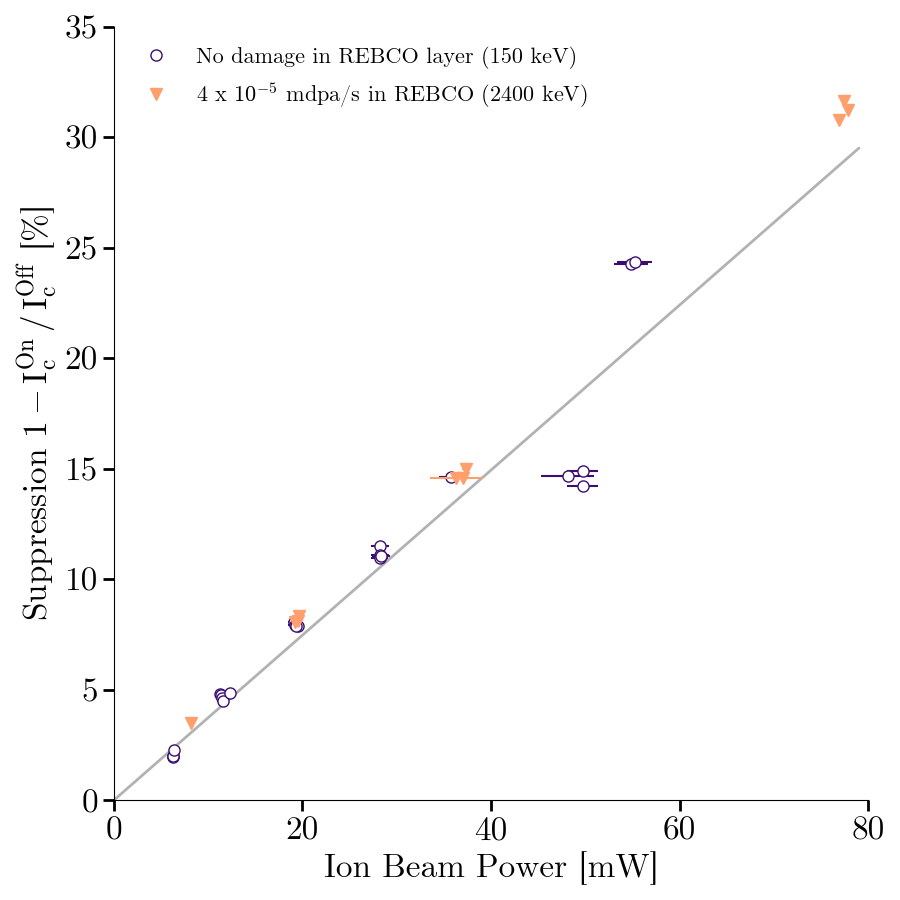

In [10]:
fig, ax = plt.subplots()
x, ex = data.power, data.powerError
y, ey = data.suppression, data.suppressionError

percent = 100 # switch suppression values to percentages

cut = (data.tapeid == 'f37') & ((data.energy == 150) | (data.energy == 2400)) & (data.power < 100)
popt, pcov = curve_fit(ff.affine, x[cut], y[cut]) 

ax.plot(np.linspace(0, 79, 10000), percent*ff.affine(np.linspace(0, 79, 10000), *popt), linewidth=2, alpha=.3, linestyle='-', color='k', solid_capstyle='round')

labels = ['No damage in REBCO layer (150 keV)', '4 x $\mathrm{10^{-5}}$ mdpa/s in REBCO (2400 keV)']
for energy, mfc, m, l in zip([150, 2400], ['white', None], ['o', 'v'], labels):
    c, cut = dfs.colors_energies[str(energy)], (df.tapeid == tapeid) & (df.energy == energy)
    ax.errorbar(x[cut], percent*y[cut], xerr=ex[cut], yerr=ey[cut], linestyle='None', color=c)
    ax.plot(x[cut], percent*y[cut], marker=m, markersize=8, linestyle='None', mfc=mfc, color=c, label=l)
    
ax.set_ylim(0, percent*0.35)
ax.set_xlim(0, 80)
ax.set_xlabel('Ion Beam Power [mW]')

if percent > 1:
    ax.set_ylabel('Suppression $\mathrm{1 - I_c^{On}\, /\, I_c^{Off}}$ [%]')
else:
    ax.set_ylabel('Suppression $\mathrm{1 - I_c^{On}\, /\, I_c^{Off}}$')
    
fig.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left', frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(outputDirectory+'150v2400keV.svg', format='svg', transparent=True)